In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy
import xml.etree.ElementTree as ET
from glob import glob
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
filename = './data/ABSjets/171129104.y14'
#filename = './data/ABSjets/1711291046.y10'
#filename = './data/ponor/1808011013.y14'
#filename = './data/ponor/1808011014.y10'
#filename = './data/17-07-2013_10-10-2013/Liulin/1307171752.y07'

# extract time
path = filename.split('/')
time = path[-1].split('.')
print time
date_object = datetime.datetime.strptime(time[0], '%y%m%d%H%M')
print date_object

# read data
liulin = pd.read_csv(filename, header = None, sep = ' ', skiprows = 1) # read Liulin data Y
liulin = liulin.drop(256, axis=1) # delete last empty column
infile = open(filename, 'r')
header = infile.readline()
print header # print data header
exposition = header.split(' ')[4].split('[')[0] # extract exposition time  
exposition_val = float(exposition)
exposition += 'S'
print exposition

# compute time series
#dates = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist()


['171129104', 'y14']
2017-11-29 10:04:00
MDU-14  EXPOSITION = 10[sec]

10S


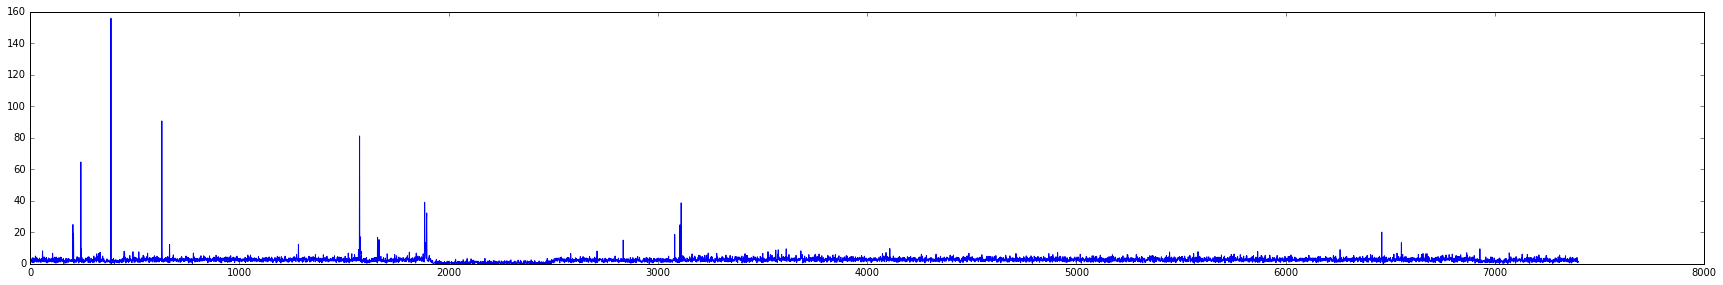

In [9]:
plt.figure(figsize=(30,5))
plt.gcf().autofmt_xdate()
#for i in range(1,3):
#    plt.plot(liulin[i][0:])

energy_scale = linspace(0.0407, 20.7977, 256)
liulin = liulin.multiply(energy_scale)
liulin[0] = liulin.sum(axis=1)
   
plt.plot(liulin[0])

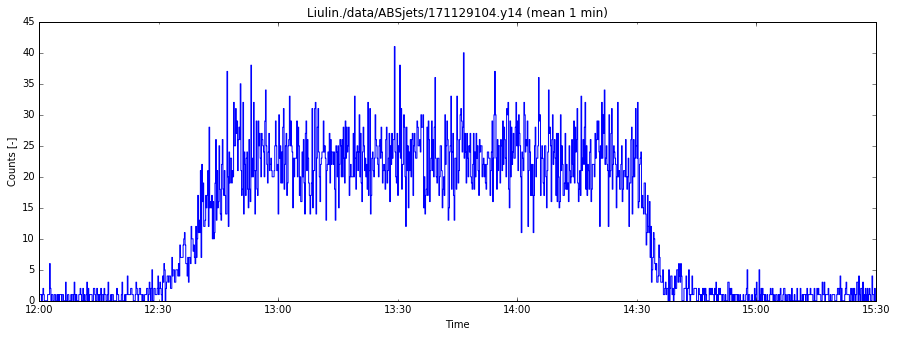

In [30]:
#liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist(), data = liulin.as_matrix())
# index liulin data (compute time)
liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq=exposition, periods=len(liulin)).tolist(), data = liulin.as_matrix())
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)
#liulin_data = liulin_data.loc['2018-08-02 17:00:00':'2018-08-03 13:00:00']
liulin_data = liulin_data.loc['2017-11-29 12:00:00':'2017-11-29 15:30:00']

sample = '1 min'
method = 'mean'
iulin_data = liulin_data.resample(sample, how=method)

#liulin_data
plt.figure(figsize=(15, 5))
liulin_data['flux'].plot(drawstyle='steps')
plt.title('Liulin' + filename + ' (' + method + ' ' + sample + ')')
plt.ylabel('Counts [-]')
plt.xlabel('Time')
#plt.ylim(0, 20)


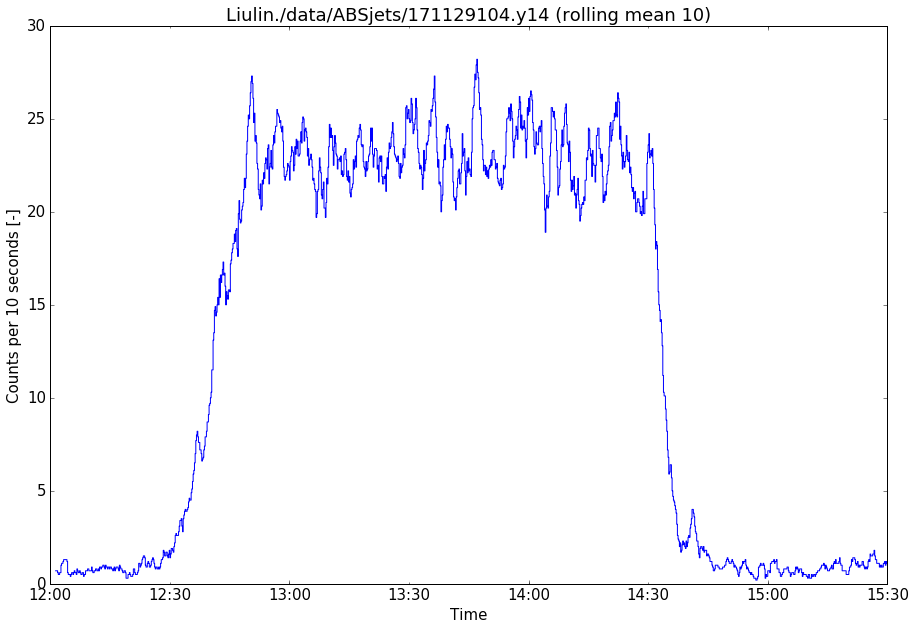

In [34]:
#liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist(), data = liulin.as_matrix())
# index liulin data (compute time)
liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq=exposition, periods=len(liulin)).tolist(), data = liulin.as_matrix())
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)
#liulin_data = liulin_data.loc['2018-08-02 17:00:00':'2018-08-03 13:00:00']
liulin_data = liulin_data.loc['2017-11-29 12:00:00':'2017-11-29 15:30:00']

WINDOW = 10
liulin_data['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

#liulin_data
plt.figure(figsize=(15, 10))
matplotlib.rcParams.update({'font.size': 15})
liulin_data['flux'].plot(drawstyle='steps')
plt.title('Liulin' + filename + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylabel('Counts per 10 seconds [-]')
plt.xlabel('Time')
#plt.ylim(0, 20)


In [38]:
import plotly.plotly as py
import plotly.graph_objs as go

LOW_ENERGY = 0

e1 = ['2017-11-29 12:00:00','2017-11-29 15:30:00']

ener1 = liulin_data.ix[e1[0]:e1[1],LOW_ENERGY:256].sum()


# Solving following system of linear equations
# 237a + b = 6.12
# 215a + b = 5.49
tl = 0.5
#l = np.array([[41, 1],[62,1]])
#r = np.array([1.02, 1.41])
l = np.array([[275, 1],[364,1]])
r = np.array([1, 5.4])

coef = np.linalg.solve(l,r)
print coef[0], coef[1]

e = pd.DataFrame()
e['1'] = ener1
e['index'] = ener1.index
#e['x'] = (e['index']) * coef[0] + coef[1]
e['x'] =  linspace(0.0407, 20.7977, 256)

data = [
    go.Scatter(
        x=e['x'],
        y=e['1'],
        name='aircraft',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    ]
        
layout = go.Layout(
    title='Liulin',
    yaxis=dict(
        title='counts',
        type='log',
        #range = [0,20000]
    ),
    xaxis=dict(
        title='ε [MeV]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ble')

0.0494382022472 -12.595505618


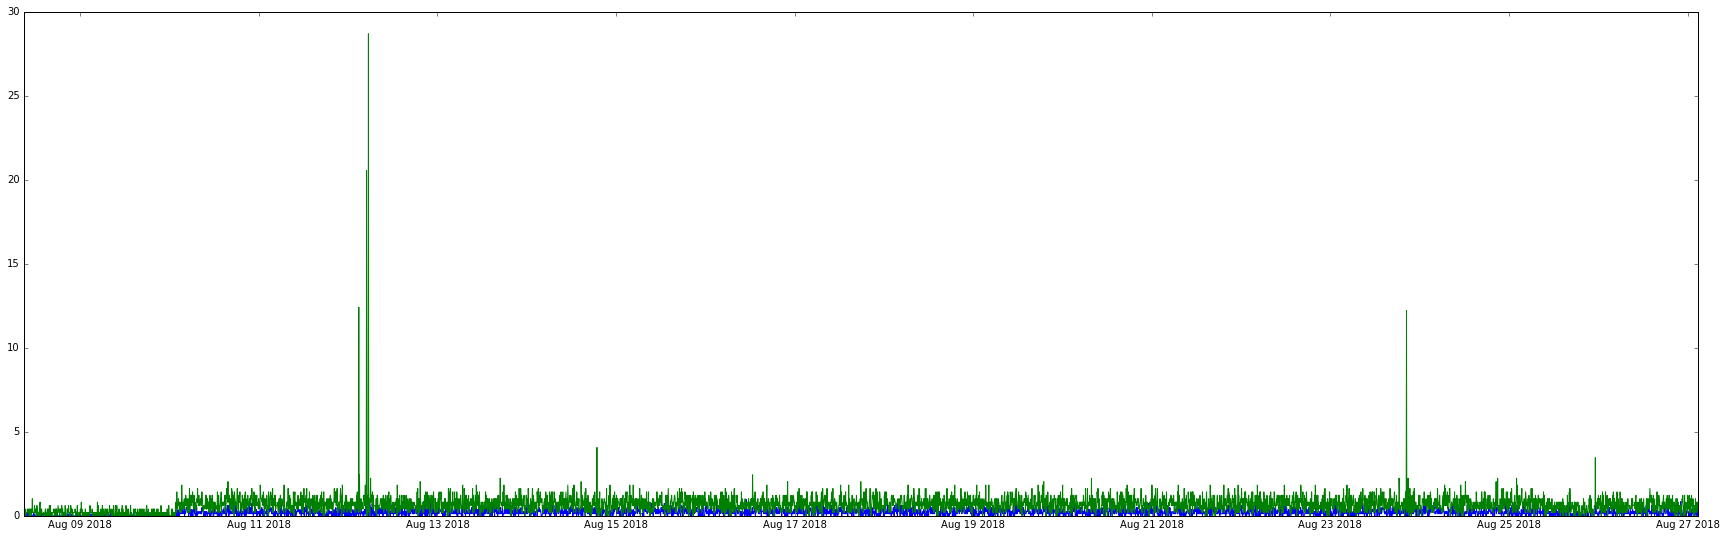

In [11]:
fromx = 2000
tox = 20000

# compute time series
dates = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist()

plt.figure(figsize=(30,10))
plt.gcf().autofmt_xdate()
for i in range(1,3):
    plt.plot(dates[fromx:tox], liulin[i][fromx:tox])

In [12]:
def round_dt(dt):
    dt = dt + datetime.timedelta(seconds=30, microseconds=999999)
    dt = dt.replace(second=0, microsecond=0)
    return dt

nav_data = pd.DataFrame()


for file in glob('./21-11-2012_3-2-2013/Navigation data/*.xml'):
    tree = ET.parse(file)
    values = tree.findall('./FlightTrack/Position')
    try:
        data = pd.DataFrame({
                         'line' : tree.find('./FlightInfo/FlightLine').text,
                         'from' : tree.find('./FlightInfo/Org').text,
                         'to' : tree.find('./FlightInfo/Dst').text,
                         'lon' : [value.find('Longtitude').text for value in values],
                         'lat' : [value.find('Latitude').text for value in values],
                         'alt' : [value.find('Baralt').text for value in values],
                         }, index=[round_dt(datetime.datetime.strptime(value.find('Time').text, "%Y-%m-%d %H:%M:%S")) for value in values])
    except:
        continue

    nav_data = pd.concat([data,nav_data])


In [14]:
#liulin_data.to_csv('./ble_li.csv')
#nav_data.to_csv('./ble_nav.csv')
data = nav_data.join(liulin_data) # join liulin data with navigation data
data = data.dropna(subset=[7]) # delele NaN lines
data.to_csv('./ble.csv')

data[['alt']] = data[['alt']].astype(float)

plt.figure(figsize=(300,10))
plt.gcf().autofmt_xdate()
plt.plot(data.index.to_pydatetime(),data[0],'r.')
plt.plot(data.index.to_pydatetime(),data['alt']/1000,'b.')
#plt.plot(data[0],data[11])



KeyError: "['alt'] not in index"

In [41]:
e.to_csv('./data/liulin.csv')